In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import pickle
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Dropout
# from keras.layers import LSTM
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
# from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import lightgbm
import logging
# from src.utils import merge_simultanous_rows, save_to_blob, data_process

In [3]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [4]:
min_max_mat=np.array([[2175,2175,1,1],[3398.25,3396.5,82120,70494]])

In [5]:
min_max_mat.shape

(2, 4)

In [6]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(min_max_mat)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [7]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs":10,
    "lr": 0.00010000,
    "time_steps": 100
}

iter_changes = "dropout_layers_0.4_0.4"

# INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
# OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/lstm_best_7-3-19_12AM/"+iter_changes
OUTPUT_PATH = '../data/models_mp_10000_0.0005'
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [8]:
def build_timeseries(mat, labels, steps, weights=None ):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - steps
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, steps, dim_1))
    y = np.zeros((dim_0,))
    w = np.zeros((dim_0,))
    print("dim_0",dim_0)
#     for i in tqdm_notebook(range(dim_0)):
    for i in range(dim_0):
        x[i] = mat[i:steps+i]
        y[i] = labels[steps+i]
        if weights is not None:
            w[i] = weights[steps+i]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y, w

In [9]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [10]:
def col_id_to_feature(ids, columns, steps):
    base_cols = [columns[id % len(columns)] for id in ids]
    lags = [id//len(columns) for id in ids]
    col_names = ['{}_lag_{}'.format(base_cols[i], lags[i]) for i in range(len(ids))]
    return base_cols, lags,  len(columns), col_names

# LGMB training

In [11]:

file_path_train_x = os.path.join('../../data/labels_with_weights/','X_train_data.npy')
file_path_train_y = os.path.join('../../data/labels_with_weights/','y_2_train_data.npy')
file_path_train_w = os.path.join('../../data/labels_with_weights/','w_train_data.npy')
file_path_test_x = os.path.join('../../data/labels_with_weights/','X_test_data.npy')
file_path_test_y = os.path.join('../../data/labels_with_weights/','y_2_test_data.npy')
file_path_test_w = os.path.join('../../data/labels_with_weights/','w_test_data.npy')

In [31]:
# base_label_cols = [
#     "long_label",
#     "long_return",
#     "long_duration",
#     "pt_long_ind",
#     "sl_long_ind",
#     "short_label",
#     "short_return",
#     "short_duration",
#     "pt_short_ind",
#     "sl_short_ind",
#     "end_ind",
# ]

X_train = np.load(file_path_train_x)
y_train_all = np.load(file_path_train_y)
# ind 1 = long return
y_train = y_train_all[:,1].reshape(len(y_train_all))
# y_train+=1
w_train = np.load(file_path_train_w)
w_train = w_train.reshape(len(w_train))


X_test = np.load(file_path_test_x)
y_test_all = np.load(file_path_test_y)
y_test = y_test_all[:,1].reshape(len(y_test_all))
# y_test+=1
w_test = np.load(file_path_test_w)
w_test = w_test.reshape(len(w_test))

print(
    "shapes of X_train {}, y_train, {}, w_train {}, X_test {}, y_test {}, w_test {}".format(
        X_train.shape, y_train.shape, w_train.shape, X_test.shape, y_test.shape, w_test.shape
    )
)

shapes of X_train (826971, 62), y_train, (826971,), w_train (826971,), X_test (206743, 62), y_test (206743,), w_test (206743,)


In [60]:
time_steps = 1

In [61]:
X_train_3d, y_train_3d, w_train_2d = build_timeseries(X_train, y_train, steps = time_steps, weights=w_train) 
X_test_3d, y_test_3d, w_test_2d = build_timeseries(X_test, y_test, steps = time_steps, weights=w_test) 

dim_0 826970
length of time-series i/o (826970, 1, 62) (826970,)
dim_0 206742
length of time-series i/o (206742, 1, 62) (206742,)


In [62]:
X_train_2d = X_train_3d.reshape(X_train_3d.shape[0],X_train_3d.shape[1]*X_train_3d.shape[2])
X_test_2d = X_test_3d.reshape(X_test_3d.shape[0],X_test_3d.shape[1]*X_test_3d.shape[2])
y_train_2d = y_train_3d
y_test_2d = y_test_3d
print(
    "shapes of X_train_2d {}, y_train, {}, X_test_2d {}, y_test_2d {}".format(
        X_train_2d.shape, y_train_2d.shape, X_test_2d.shape, y_test_2d.shape
    )
)

shapes of X_train_2d (826970, 62), y_train, (826970,), X_test_2d (206742, 62), y_test_2d (206742,)


In [73]:
model = LinearRegression()
model.fit(X_train_2d, y_train_2d)#, sample_weight=w_train_2d)
y_pred = model.predict(X_test_2d)



In [74]:
y_pred_bin =[1 if y>0 else 0 for y in y_pred]
y_test_2d_bin = [1 if y>0 else 0 for y in y_test_2d]
# y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test_2d_bin, y_pred_bin, target_names=['loss','gain']))

              precision    recall  f1-score   support

        loss       0.53      0.79      0.63    107706
        gain       0.49      0.22      0.31     99036

    accuracy                           0.52    206742
   macro avg       0.51      0.51      0.47    206742
weighted avg       0.51      0.52      0.48    206742



In [75]:
ret_test = y_test_all[:,1].reshape(len(y_test_all))
hold_test = y_test_all[:,2].reshape(len(y_test_all))
bar_duration_test = y_test_all[:,3].reshape(len(y_test_all))
ret_test = ret_test[time_steps:]
hold_test = hold_test[time_steps:]
bar_duration_test = bar_duration_test[time_steps:]

In [76]:
from enum import Enum
class BidState(Enum):
    CASH=1
    LONG=2
    SHORT=0

In [77]:
def single_unit_trade(y_pred, ret, hold_duration, bar_duration, labels=[0,1]):
    ret_sum = 0
    hold_time = 0
    bar_separation = 0
    state=BidState.CASH
    # loop over all test values
    for i,pred in enumerate(y_pred):
        if state==BidState.LONG:
            bar_separation +=bar_duration[i]
            if bar_separation>= hold_time:
                state=BidState.CASH
                
        if state==BidState.CASH and pred==labels[1]:
                state=BidState.LONG
                hold_time = hold_duration[i]
                ret_sum += ret[i]
    return ret_sum




single_unit_trade(y_pred_bin, ret_test, hold_test, bar_duration_test, labels=[0,1])    

0.5

In [78]:
len(ret_test)

206742

In [63]:
name, model = 'RFC',RandomForestRegressor(n_estimators=40, verbose = 2, n_jobs=-1)
model.fit(X_train_2d, y_train_2d)
y_pred = model.predict(X_test_2d)
y_pred_bin =[1 if y>0 else 0 for y in y_pred]
y_test_2d_bin = [1 if y>0 else 0 for y in y_test_2d]
# y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test_2d_bin, y_pred_bin, target_names=['loss','gain']))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min


building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:  4.4min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:    0.1s finished


              precision    recall  f1-score   support

        loss       0.52      0.77      0.62    107706
        gain       0.46      0.22      0.29     99036

    accuracy                           0.50    206742
   macro avg       0.49      0.49      0.46    206742
weighted avg       0.49      0.50      0.46    206742



In [64]:
train_data = lightgbm.Dataset(X_train_2d, label=y_train_2d, weight = w_train_2d)
# val_data = lightgbm.Dataset(X_val_2d, label=y_val, reference=train_data)
test_data = lightgbm.Dataset(X_test_2d, label=y_test_2d, weight = w_test_2d)

In [65]:
# parameters = {
#     'objective': 'multiclass',
# #     'metric': 'multi_logloss,auc_mu',
#     'metric': 'multi_logloss',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_class':3,
#     'metric_freq': 1,
#     'is_training_metric':'true',
#     'learning_rate':0.05,
#     'num_leaves': 5,
#     'num_trees':100,
#     'feature_fraction': 0.43,
#     'bagging_fraction': 0.48,
#     'bagging_freq': 4,
#     'min_data_in_leaf':50,
#     'learning_rate': 0.05,
#     'verbose': 1,
#     'early_stopping_round':10
# }

parameters = {
        "objective": "regression",
        "metric": "l2",
#         'is_unbalance': 'true',
#         'boosting': 'gbdt',
#         'metric_freq': 1,
#         'is_training_metric':'true',
#         'learning_rate':0.04,
#         'num_leaves': 30,
#         'num_trees':100,
#         'feature_fraction': 1,
#         'bagging_fraction': 0.48,
#         'bagging_freq': 6,
#         'min_data_in_leaf':30,
#         'learning_rate': 0.04,
#         'verbose': 1,
#         'early_stopping_round':10
    }

In [66]:
print('Starting training...')
# train
gbm = lightgbm.train(params=parameters,
                     train_set = train_data,
                     valid_sets=[train_data,test_data])

Starting training...
[1]	training's l2: 3.85469	valid_1's l2: 14.5859
[2]	training's l2: 3.84209	valid_1's l2: 14.6454
[3]	training's l2: 3.83133	valid_1's l2: 14.7018
[4]	training's l2: 3.82225	valid_1's l2: 14.7916
[5]	training's l2: 3.81381	valid_1's l2: 14.7847
[6]	training's l2: 3.80633	valid_1's l2: 14.8619
[7]	training's l2: 3.7989	valid_1's l2: 14.8719
[8]	training's l2: 3.79145	valid_1's l2: 14.8797
[9]	training's l2: 3.7852	valid_1's l2: 14.8876
[10]	training's l2: 3.77907	valid_1's l2: 14.9473
[11]	training's l2: 3.77223	valid_1's l2: 14.9717
[12]	training's l2: 3.76707	valid_1's l2: 15.1063
[13]	training's l2: 3.76112	valid_1's l2: 15.1373
[14]	training's l2: 3.75643	valid_1's l2: 15.1614
[15]	training's l2: 3.75096	valid_1's l2: 15.1675
[16]	training's l2: 3.74559	valid_1's l2: 15.2511
[17]	training's l2: 3.74055	valid_1's l2: 15.2551
[18]	training's l2: 3.73571	valid_1's l2: 15.2431
[19]	training's l2: 3.73134	valid_1's l2: 15.3413
[20]	training's l2: 3.72685	valid_1's l2

In [67]:
y_pred = gbm.predict(X_test_2d)
y_pred_bin =[1 if y>0 else 0 for y in y_pred]
y_test_2d_bin = [1 if y>0 else 0 for y in y_test_2d]
# y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test_2d_bin, y_pred_bin, target_names=['loss','gain']))


              precision    recall  f1-score   support

        loss       0.52      0.63      0.57    107706
        gain       0.47      0.36      0.41     99036

    accuracy                           0.50    206742
   macro avg       0.50      0.50      0.49    206742
weighted avg       0.50      0.50      0.49    206742



In [70]:
single_unit_trade(y_pred_bin, ret_test, hold_test, bar_duration_test, labels=[0,1])    

0.0

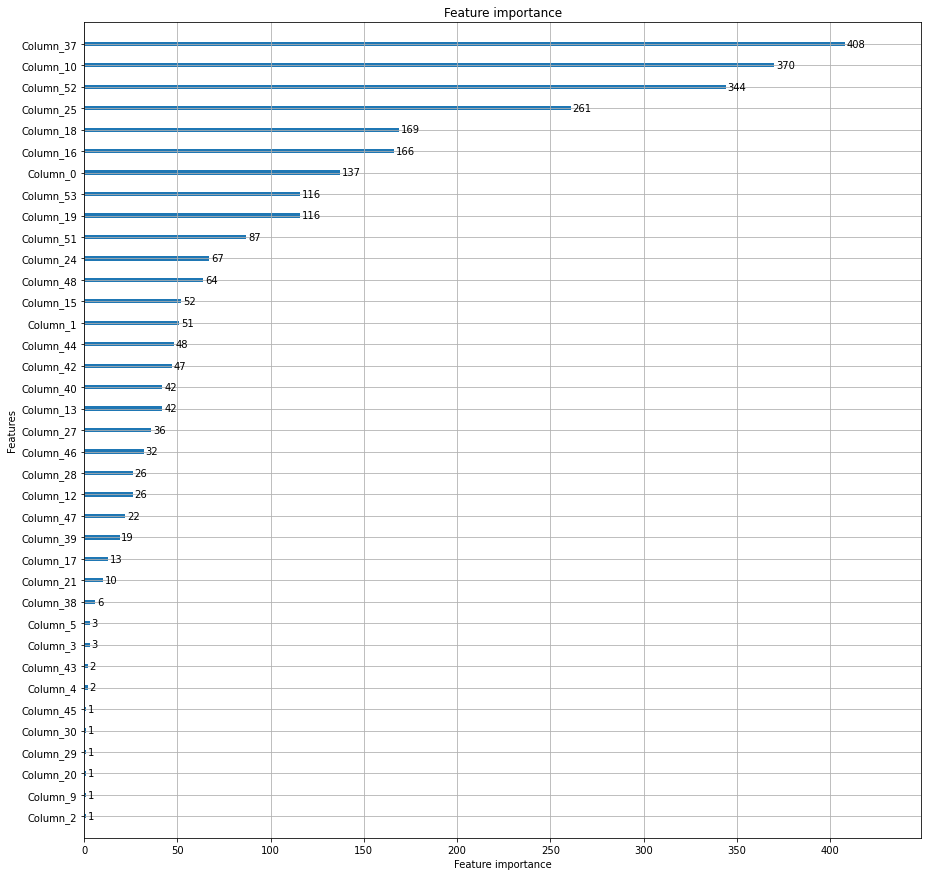

In [21]:
ax = lightgbm.plot_importance(gbm, max_num_features=40, figsize=(15,15))


In [46]:
features = ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size', 'Bid Price_diff', 'Ask Price_diff', 'Bid Size_diff', 'Ask Size_diff', 'BidAskRatio', 'TWBidAskRatio']
ffd_features = [f'ffd_{feature}' for feature in features]
features = features + ffd_features
def col_id_to_feature(ids, columns, steps):
    base_cols = [columns[id % len(columns)] for id in ids]
    lags =  [(steps -1) - (id//len(columns)) for id in ids]
    col_names = ['{}_lag_{}'.format(base_cols[i], lags[i]) for i in range(len(ids))]
    return col_names
col_id_to_feature([1990,1991, 1950, 1981,1971,1951, 1980, 1962, 1240],columns = features,steps=100)


['ffd_Bid Price_lag_0',
 'ffd_Ask Price_lag_0',
 'ffd_Bid Price_lag_2',
 'Ask Price_lag_0',
 'ffd_Ask Price_lag_1',
 'ffd_Ask Price_lag_2',
 'Bid Price_lag_0',
 'Bid Size_lag_1',
 'Bid Price_lag_37']

# LGBM no lag
             precision    recall  f1-score   support

        loss       0.46      0.52      0.49     58643
      no hit       0.50      0.00      0.00     13300
        gain       0.46      0.50      0.48     56521

    accuracy                           0.46    128464
   macro avg       0.47      0.34      0.32    128464
weighted avg       0.46      0.46      0.43    128464
```['Bid Price_lag_0',
 'Ask Price_lag_0',
 'ffd_Bid Price_lag_0',
 'ffd_Ask Price_lag_0',
 'Bid Size_lag_0',
 'ffd_Ask Size_lag_0',
 'ffd_Bid Size_lag_0']```

# lgbm on 100 days lag, base cols
y_pred = gbm.predict(X_test_2d)
y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_flat, target_names=['loss','no hit','gain']))
              precision    recall  f1-score   support

        loss       0.42      0.60      0.49     52110
      no hit       0.72      0.01      0.01     21360
        gain       0.41      0.40      0.41     51010

    accuracy                           0.42    124480
   macro avg       0.52      0.33      0.30    124480
weighted avg       0.47      0.42      0.37    124480

In [100]:
# # prepare configuration for cross validation test harness
# seed = 7
# # prepare models
# models = []
# # models.append(('LR', LogisticRegression()))
# # models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('RFC',RandomForestClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('NN', MLPClassifier(alpha=1)))
# models.append(('QDA',QuadraticDiscriminantAnalysis()))
# models.append(('SVM', SVC()))
# # evaluate each model in turn
# results = []
# results_cust=[]
# names = []
# scoring = 'accuracy'
# print('Subscribers:')
# for name, model in models:
#     model.fit(X_train_2d, y_train_2d)
#     y_pred = gbm.predict(X_test_2d)
#     y_pred_flat = np.argmax(y_pred, axis=1)
#     cm = confusion_matrix(y_test, y_pred_flat)

#     print("{} gain precision: {:.2f}".format(name, cm[2,2]/sum(cm[:,2])))
#     print(classification_report(y_test, y_pred_flat, target_names=['loss','no hit','gain']))
# print('Customers:')

In [21]:
name = "LR"
model = LogisticRegression()
model.fit(X_train_2d, y_train_2d, sample_weight=w_train_2d)
y_pred_flat = model.predict(X_test_2d)
cm = confusion_matrix(y_test_2d, y_pred_flat)

print("{} gain precision: {:.2f}".format(name, cm[2,2]/sum(cm[:,2])))
print(classification_report(y_test_2d, y_pred_flat, target_names=['loss','no hit','gain']))

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR gain precision: 0.43
              precision    recall  f1-score   support

        loss       0.54      0.31      0.40     74704
      no hit       0.47      0.99      0.64     72883
        gain       0.43      0.08      0.14     59136

    accuracy                           0.48    206723
   macro avg       0.48      0.46      0.39    206723
weighted avg       0.49      0.48      0.41    206723



In [29]:
cm = confusion_matrix(y_test_2d, y_pred_flat)
print("{} gain precision: {:.2f}".format(name, cm[2,2]/sum(cm[:,2])))
print(classification_report(y_test_2d, y_pred_flat, target_names=['loss','no hit','gain']))

LR gain precision: 0.49
              precision    recall  f1-score   support

        loss       0.48      0.27      0.34     69353
      no hit       0.49      0.96      0.65     72676
        gain       0.49      0.20      0.28     64614

    accuracy                           0.49    206643
   macro avg       0.49      0.47      0.42    206643
weighted avg       0.49      0.49      0.43    206643



# LR lag 10
LR gain precision: 0.48
```
              precision    recall  f1-score   support

        loss       0.45      0.87      0.59     58633
      no hit       0.30      0.00      0.00     13300
        gain       0.48      0.13      0.21     56521

    accuracy                           0.46    128454
   macro avg       0.41      0.33      0.27    128454
weighted avg       0.45      0.46      0.36    128454

```
```
feature imporance 
['ffd_Bid Size_lag_0',
 'ffd_Bid Size_lag_1',
 'ffd_Ask Size_lag_0',
 'ffd_Ask Size_lag_1',
 'ffd_Bid Size_lag_2',
 'ffd_Ask Size_lag_2',
 'ffd_Bid Size_lag_3',
 'ffd_Ask Size_lag_3',
 'ffd_Bid Size_lag_4',
 'ffd_Bid Size_lag_5']
 ```

In [117]:
arr = model.coef_[2]

top_feature_inds = arr.argsort()[::-1][:10]
features = ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size', 'Bid Price_diff', 'Ask Price_diff', 'Bid Size_diff', 'Ask Size_diff', 'BidAskRatio', 'TWBidAskRatio']
ffd_features = [f'ffd_{feature}' for feature in features]
features = features + ffd_features
def col_id_to_feature(ids, columns, steps):
    base_cols = [columns[id % len(columns)] for id in ids]
    lags = [id//len(columns) for id in ids]
    col_names = ['{}_lag_{}'.format(base_cols[i], lags[i]) for i in range(len(ids))]
    return col_names
col_id_to_feature(top_feature_inds,columns = features,steps=10)

['ffd_Bid Size_lag_0',
 'ffd_Bid Size_lag_1',
 'ffd_Ask Size_lag_0',
 'ffd_Ask Size_lag_1',
 'ffd_Bid Size_lag_2',
 'ffd_Ask Size_lag_2',
 'ffd_Bid Size_lag_3',
 'ffd_Ask Size_lag_3',
 'ffd_Bid Size_lag_4',
 'ffd_Bid Size_lag_5']

In [66]:
name, model = 'RFC',RandomForestClassifier(n_estimators=40, verbose = 2, n_jobs=-1)
model.fit(X_train_2d, y_train_2d)
y_pred_flat = model.predict(X_test_2d)
cm = confusion_matrix(y_test_2d, y_pred_flat)

print("{} gain precision: {:.2f}".format(name, cm[2,2]/sum(cm[:,2])))
print(classification_report(y_test_2d, y_pred_flat, target_names=['loss','no hit','gain']))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40

building tree 4 of 40

building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.5min


building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    1.3s finished


RFC gain precision: 0.42
              precision    recall  f1-score   support

        loss       0.31      0.60      0.41     69404
      no hit       0.45      0.18      0.26     72715
        gain       0.42      0.29      0.34     64614

    accuracy                           0.36    206733
   macro avg       0.40      0.36      0.34    206733
weighted avg       0.40      0.36      0.34    206733



base lgbm results:
           precision    recall  f1-score   support

        loss       0.42      0.60      0.49     52110
      no hit       0.72      0.01      0.01     21360
        gain       0.41      0.40      0.41     51010

    accuracy                           0.42    124480
   macro avg       0.52      0.33      0.30    124480
weighted avg       0.47      0.42      0.37    124480

In [ ]:
name, model = 'Tree',DecisionTreeClassifier()
model.fit(X_train_2d, y_train_2d)
y_pred_flat = model.predict(X_test_2d)
cm = confusion_matrix(y_test_2d, y_pred_flat)

print("{} gain precision: {:.2f}".format(name, cm[2,2]/sum(cm[:,2])))
print(classification_report(y_test_2d, y_pred_flat, target_names=['loss','no hit','gain']))

In [17]:
def create_model(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [135]:
verbose, epochs, batch_size = 1, 15, 64
model = create_model(TIME_STEPS, X_train.shape[2],y_train.shape[1])
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
15568/15568 [==============================] - 3628s 232ms/step - loss: 0.9948 - accuracy: 0.4277 - val_loss: 0.8799 - val_accuracy: 0.4697
Epoch 2/15
15568/15568 [==============================] - 3425s 220ms/step - loss: 0.9729 - accuracy: 0.4395 - val_loss: 0.8504 - val_accuracy: 0.4852
Epoch 3/15
15568/15568 [==============================] - 4597s 295ms/step - loss: 0.9564 - accuracy: 0.4516 - val_loss: 0.8783 - val_accuracy: 0.4833
Epoch 4/15
15568/15568 [==============================] - 1810s 116ms/step - loss: 0.9500 - accuracy: 0.4536 - val_loss: 0.8563 - val_accuracy: 0.4771
Epoch 5/15
15568/15568 [==============================] - 1838s 118ms/step - loss: 0.9502 - accuracy: 0.4513 - val_loss: 0.8436 - val_accuracy: 0.4820
Epoch 6/15
15568/15568 [==============================] - 12752s 819ms/step - loss: 0.9452 - accuracy: 0.4559 - val_loss: 0.8713 - val_accuracy: 0.4712
Epoch 7/15
15568/15568 [==============================] - 19089s 1s/step - loss: 0.9438 - acc

KeyboardInterrupt: 

In [28]:
model = None
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    from keras import backend as K
    K.tensorflow_backend._get_available_gpus()
    print("Building model...")
    #     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model(TIME_STEPS, X_train.shape[2], y_train.shape[1])

    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=1, patience=40, min_delta=0.0001
    )

    mcp = ModelCheckpoint(
        os.path.join(OUTPUT_PATH, "best_model.h5"),
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        period=1,
    )

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=30,
        verbose=0,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,
    )

    csv_logger = CSVLogger(
        os.path.join(
            OUTPUT_PATH,
            "training_log_" + time.ctime().replace(" ", "_").replace(":", "_") + ".log",
        ),
        append=True,
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=params["epochs"],
        verbose=2,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_data=(
            trim_dataset(X_val, BATCH_SIZE),
            trim_dataset(y_val, BATCH_SIZE),
        ),
        callbacks=[es, mcp, csv_logger],
        use_multiprocessing=False,
    )

#     print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))

Building model...
Epoch 1/10
500/500 - 31s - loss: 1.1005 - accuracy: 0.3485 - val_loss: 1.0539 - val_accuracy: 0.4810

Epoch 00001: val_loss improved from inf to 1.05393, saving model to ../data/models_mp_10000_0.0005\best_model.h5
Epoch 2/10
500/500 - 27s - loss: 1.1054 - accuracy: 0.3565 - val_loss: 1.0592 - val_accuracy: 0.4810

Epoch 00002: val_loss did not improve from 1.05393
Epoch 3/10
500/500 - 27s - loss: 1.0973 - accuracy: 0.3695 - val_loss: 1.0678 - val_accuracy: 0.4810

Epoch 00003: val_loss did not improve from 1.05393
Epoch 4/10
500/500 - 33s - loss: 1.0973 - accuracy: 0.3713 - val_loss: 1.0742 - val_accuracy: 0.4810

Epoch 00004: val_loss did not improve from 1.05393
Epoch 5/10
500/500 - 27s - loss: 1.0978 - accuracy: 0.3720 - val_loss: 1.0729 - val_accuracy: 0.4810

Epoch 00005: val_loss did not improve from 1.05393
Epoch 6/10
500/500 - 27s - loss: 1.0983 - accuracy: 0.3682 - val_loss: 1.0796 - val_accuracy: 0.4810

Epoch 00006: val_loss did not improve from 1.05393
Ep

In [2]:
print(
    "shapes of x_train {}, y_train, {}, x_test {}, y_test {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

NameError: name 'X_train' is not defined

In [38]:
import keras
model = keras.models.load_model("../data/models_mp_10000_0.0005/model_1000_0.0005_full_data_basic_cols")

In [39]:
from sklearn.metrics import confusion_matrix
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()
# error = mean_squared_error(y_test, y_pred)
# print("Error is", error, y_pred.shape, y_test.shape)



In [56]:
y_pred_flat = np.argmax(y_pred, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [52]:
np.argmax(a, axis=1)

array([2, 1], dtype=int64)

In [40]:
from sklearn.metrics import accuracy_score

In [62]:
print(accuracy_score(y_test_flat, y_pred_flat))
confusion_matrix(y_test_flat, y_pred_flat)

0.4179305912596401


array([[25870,   734, 25512],
       [11875,  1353,  8128],
       [25533,   674, 24801]], dtype=int64)

In [64]:
print(classification_report(y_test_flat, y_pred_flat, target_names=['loss','no hit','gain']))

              precision    recall  f1-score   support

        loss       0.41      0.50      0.45     52116
      no hit       0.49      0.06      0.11     21356
        gain       0.42      0.49      0.45     51008

    accuracy                           0.42    124480
   macro avg       0.44      0.35      0.34    124480
weighted avg       0.43      0.42      0.39    124480



In [59]:
y_pred_bin = [0 if y<=1 else 1 for y in y_pred_flat]
y_test_bin = [0 if y<=1 else 1 for y in y_test_flat]

In [60]:
print(accuracy_score(y_test_bin, y_pred_bin))
confusion_matrix(y_test_bin, y_pred_bin)

0.519223971722365


array([[39832, 33640],
       [26207, 24801]], dtype=int64)

In [61]:

print(classification_report(y_test_bin, y_pred_bin, target_names=['hold','buy']))

              precision    recall  f1-score   support

        hold       0.60      0.54      0.57     73472
         buy       0.42      0.49      0.45     51008

    accuracy                           0.52    124480
   macro avg       0.51      0.51      0.51    124480
weighted avg       0.53      0.52      0.52    124480



In [ ]:
y_test_bin = [0 if y<=1 else 1 for y in y_test]
y_pred_bin = [0 if y<=1 else 1 for y in y_pred]

Error is 0.0013806269146593734 (1360,) (1360,)
[0.39414594 0.39405537 0.39396402 0.39367312 0.39347526 0.39326194
 0.3930657  0.39281115 0.39259958 0.39241716 0.39240378 0.3929605
 0.39265734 0.39223102 0.39182454]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[19.219177 19.214867 19.210518 19.196672 19.187256 19.177101 19.16776
 19.155645 19.145575 19.136892 19.136255 19.162754 19.148325 19.128033
 19.108686]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


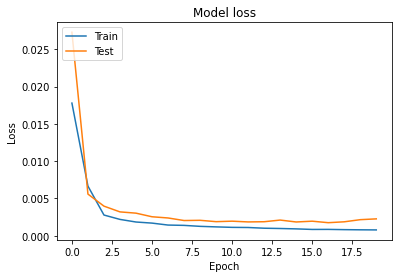

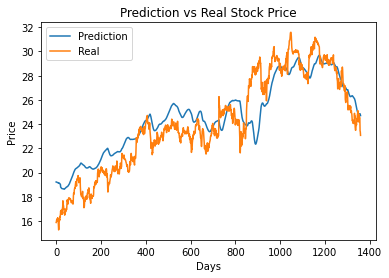

In [36]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime().replace(":","_")+'.png'))

# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime().replace(":","_")+'.png'))
# print_time("program completed ", stime)


![image.png](attachment:image.png)

In [34]:
len(df_esv_data[df_esv_data['Date']<'2018-01-01'])

251